In [1]:
# Imports
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import time
import os

# Local imports
from data.dataset import create_datasets, create_dataloaders
from models.efficientnet import create_efficientnet_b0
from models.cnn import create_custom_cnn
from utils.training import load_checkpoint, MetricsCalculator

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1+cu126
CUDA available: True
GPU: NVIDIA GeForce RTX 3080 Laptop GPU


## 1. Configuration

In [2]:
# Configuration
class Config:
    # Paths
    DATA_DIR = project_root.parent / 'data' / 'processed'
    CHECKPOINT_DIR = project_root.parent / 'models_exported'
    RESULTS_DIR = project_root.parent / 'results'
    
    # Model checkpoints
    EFFICIENTNET_CKPT = CHECKPOINT_DIR / 'efficientnet_best.pth'
    CNN_CKPT = CHECKPOINT_DIR / 'custom_cnn_best.pth'
    
    # Model
    NUM_CLASSES = 38
    IMAGE_SIZE = 224
    
    # Data
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    
    # Device
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Config()

# Create results directory
config.RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {config.DATA_DIR}")
print(f"Results directory: {config.RESULTS_DIR}")
print(f"Device: {config.DEVICE}")

Data directory: d:\Repos\plant-disease-project\data\processed
Results directory: d:\Repos\plant-disease-project\results
Device: cuda


## 2. Load Test Data

In [3]:
# Create datasets first
train_dataset, val_dataset, test_dataset = create_datasets(
    data_dir=config.DATA_DIR,
    image_size=config.IMAGE_SIZE
)

# Create data loaders
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    batch_size=config.BATCH_SIZE,
    num_workers=config.NUM_WORKERS
)

# Get class names from dataset
class_names = test_dataset.classes

print(f"Number of classes: {len(class_names)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Test batches: {len(test_loader)}")

Number of classes: 38
Test samples: 5459
Test batches: 171


## 3. Load Models

In [4]:
# Load EfficientNet-B0
efficientnet = create_efficientnet_b0(
    num_classes=config.NUM_CLASSES,
    pretrained=False
)

if config.EFFICIENTNET_CKPT.exists():
    ckpt = load_checkpoint(config.EFFICIENTNET_CKPT, efficientnet)
    print(f"Loaded EfficientNet-B0 from epoch {ckpt['epoch']}")
    print(f"  Val Accuracy: {ckpt['best_metric']:.4f}")
else:
    print(f"Warning: EfficientNet checkpoint not found at {config.EFFICIENTNET_CKPT}")

efficientnet = efficientnet.to(config.DEVICE)
efficientnet.eval()

print(f"EfficientNet-B0 parameters: {efficientnet.get_num_params():,}")

Backbone frozen. Only classifier head will be trained.
Loaded EfficientNet-B0 from epoch 19
  Val Accuracy: 0.9958
EfficientNet-B0 parameters: 48,678


In [5]:
# Load Custom CNN
custom_cnn = create_custom_cnn(
    num_classes=config.NUM_CLASSES,
    variant='standard'
)

if config.CNN_CKPT.exists():
    ckpt = load_checkpoint(config.CNN_CKPT, custom_cnn)
    print(f"Loaded Custom CNN from epoch {ckpt['epoch']}")
    print(f"  Val Accuracy: {ckpt['best_metric']:.4f}")
else:
    print(f"Warning: Custom CNN checkpoint not found at {config.CNN_CKPT}")

custom_cnn = custom_cnn.to(config.DEVICE)
custom_cnn.eval()

print(f"Custom CNN parameters: {custom_cnn.get_num_params():,}")

Loaded Custom CNN from epoch 15
  Val Accuracy: 0.9544
Custom CNN parameters: 4,857,286


## 4. Evaluation Functions

In [6]:
def evaluate_model(model, test_loader, device, model_name="Model"):
    """
    Evaluate a model on the test set.
    
    Returns:
        dict: Evaluation results including predictions, labels, and timing
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total_time = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            inputs = inputs.to(device)
            
            # Time inference
            start_time = time.time()
            outputs = model(inputs)
            if device == 'cuda':
                torch.cuda.synchronize()
            total_time += time.time() - start_time
            
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'total_time': total_time,
        'samples_per_second': len(all_preds) / total_time
    }


def get_model_size(model):
    """Get model size in MB."""
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / 1024 / 1024


print("Evaluation functions defined.")

Evaluation functions defined.


## 5. Evaluate Both Models

In [7]:
# Evaluate EfficientNet-B0
efficientnet_results = evaluate_model(
    efficientnet, test_loader, config.DEVICE, "EfficientNet-B0"
)

# Evaluate Custom CNN
cnn_results = evaluate_model(
    custom_cnn, test_loader, config.DEVICE, "Custom CNN"
)

print("\nEvaluation complete!")

Evaluating EfficientNet-B0:   0%|          | 0/171 [00:00<?, ?it/s]

Evaluating Custom CNN:   0%|          | 0/171 [00:00<?, ?it/s]


Evaluation complete!


## 6. Model Comparison Summary

In [8]:
# Calculate metrics
metrics_calc = MetricsCalculator(num_classes=config.NUM_CLASSES)

efficientnet_metrics = metrics_calc.calculate(
    efficientnet_results['labels'],
    efficientnet_results['predictions']
)

cnn_metrics = metrics_calc.calculate(
    cnn_results['labels'],
    cnn_results['predictions']
)

# Create comparison table
comparison_data = {
    'Metric': [
        'Test Accuracy',
        'F1 Score (Macro)',
        'F1 Score (Weighted)',
        'Parameters',
        'Model Size (MB)',
        'Inference Speed (samples/sec)'
    ],
    'EfficientNet-B0': [
        f"{efficientnet_metrics['accuracy']:.4f}",
        f"{efficientnet_metrics['f1_macro']:.4f}",
        f"{efficientnet_metrics['f1_weighted']:.4f}",
        f"{efficientnet.get_num_params():,}",
        f"{get_model_size(efficientnet):.2f}",
        f"{efficientnet_results['samples_per_second']:.1f}"
    ],
    'Custom CNN': [
        f"{cnn_metrics['accuracy']:.4f}",
        f"{cnn_metrics['f1_macro']:.4f}",
        f"{cnn_metrics['f1_weighted']:.4f}",
        f"{custom_cnn.get_num_params():,}",
        f"{get_model_size(custom_cnn):.2f}",
        f"{cnn_results['samples_per_second']:.1f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(comparison_df.to_string(index=False))


MODEL COMPARISON SUMMARY
                       Metric EfficientNet-B0 Custom CNN
                Test Accuracy          0.9971     0.9560
             F1 Score (Macro)          0.9957     0.9377
          F1 Score (Weighted)          0.9971     0.9576
                   Parameters          48,678  4,857,286
              Model Size (MB)           15.63      18.54
Inference Speed (samples/sec)          1132.7      935.0


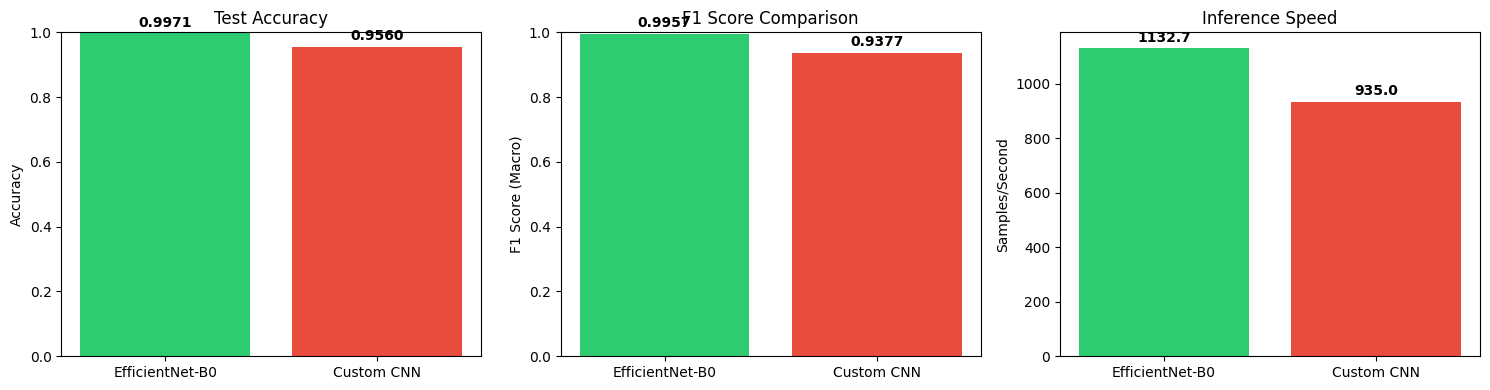

In [9]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models = ['EfficientNet-B0', 'Custom CNN']
colors = ['#2ecc71', '#e74c3c']

# Accuracy comparison
accuracies = [efficientnet_metrics['accuracy'], cnn_metrics['accuracy']]
axes[0].bar(models, accuracies, color=colors)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Test Accuracy')
axes[0].set_ylim(0, 1)
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# F1 Score comparison
f1_scores = [efficientnet_metrics['f1_macro'], cnn_metrics['f1_macro']]
axes[1].bar(models, f1_scores, color=colors)
axes[1].set_ylabel('F1 Score (Macro)')
axes[1].set_title('F1 Score Comparison')
axes[1].set_ylim(0, 1)
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# Inference speed comparison
speeds = [efficientnet_results['samples_per_second'], cnn_results['samples_per_second']]
axes[2].bar(models, speeds, color=colors)
axes[2].set_ylabel('Samples/Second')
axes[2].set_title('Inference Speed')
for i, v in enumerate(speeds):
    axes[2].text(i, v + max(speeds)*0.02, f'{v:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(config.RESULTS_DIR / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Confusion Matrices

In [10]:
def plot_confusion_matrix(labels, predictions, class_names, title, save_path=None):
    """Plot a confusion matrix."""
    cm = confusion_matrix(labels, predictions)
    
    # Normalize
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(16, 14))
    sns.heatmap(
        cm_normalized, 
        annot=False,  # Too many classes for annotations
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax
    )
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(rotation=0, fontsize=6)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    return cm

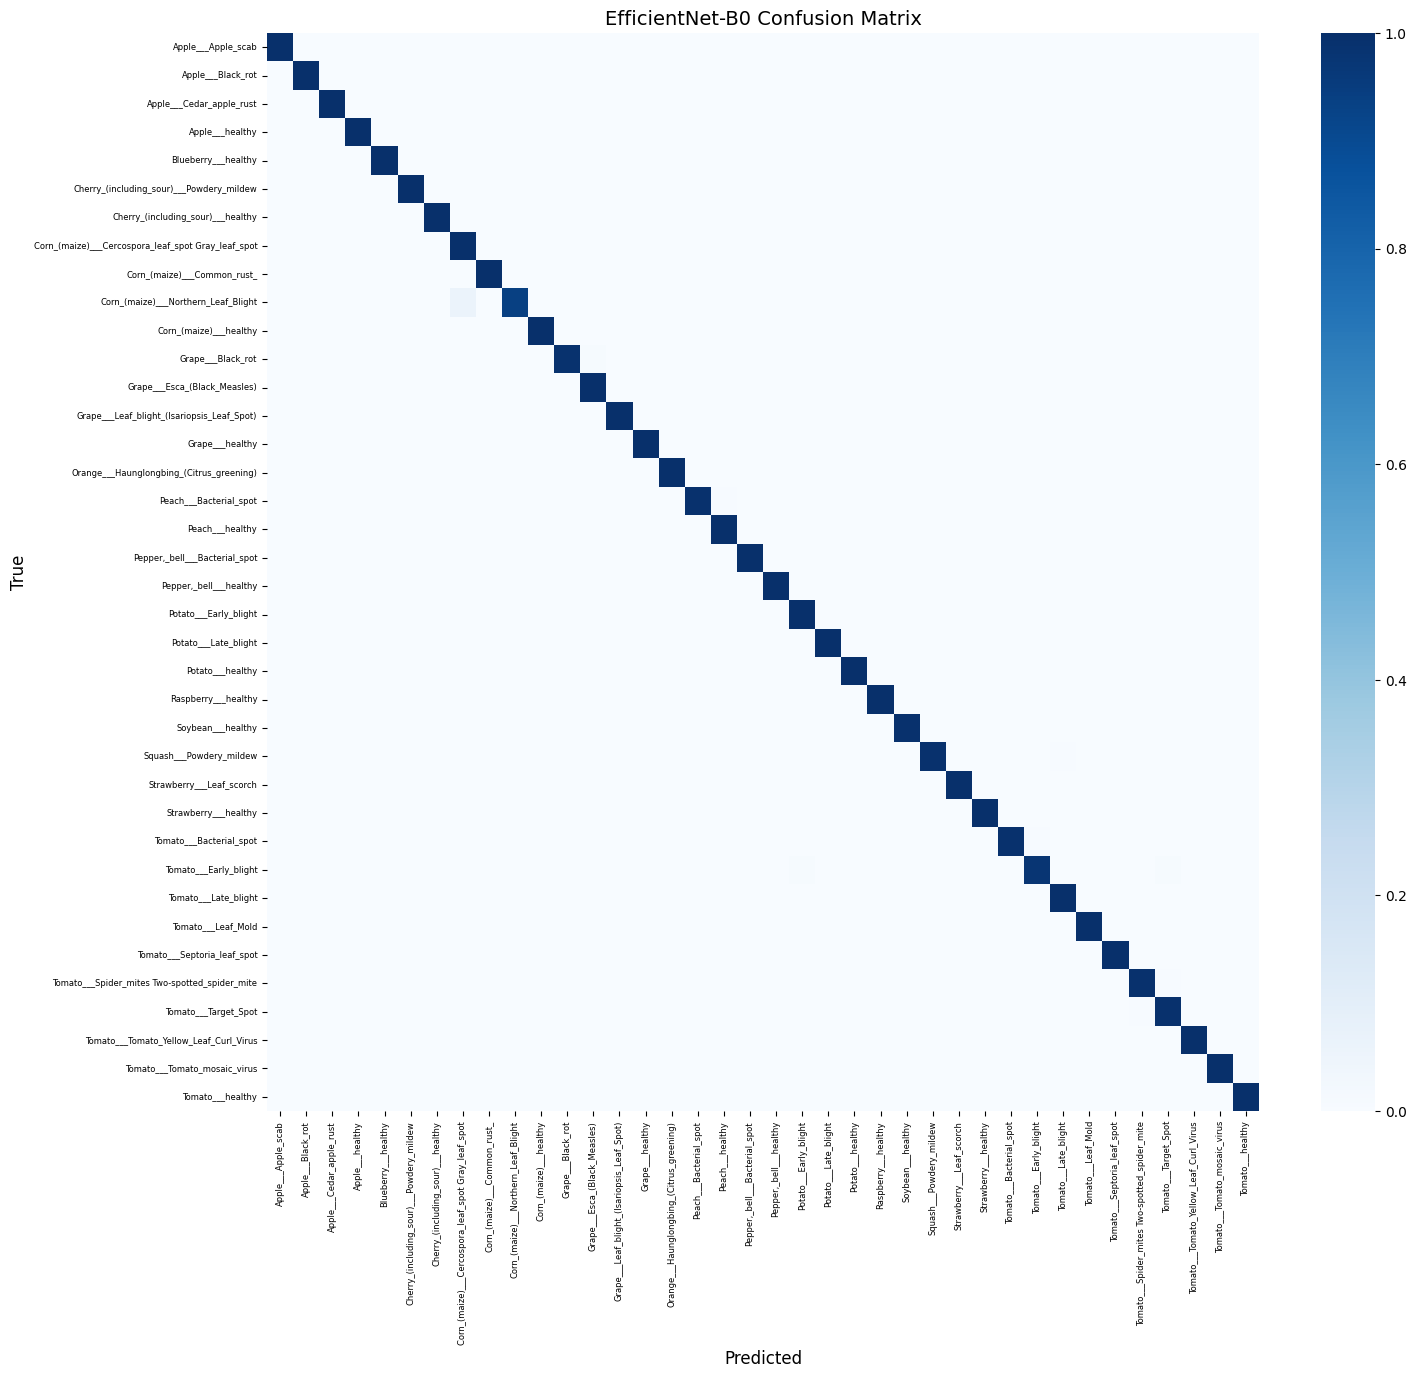

In [11]:
# EfficientNet confusion matrix
cm_efficientnet = plot_confusion_matrix(
    efficientnet_results['labels'],
    efficientnet_results['predictions'],
    class_names,
    'EfficientNet-B0 Confusion Matrix',
    config.RESULTS_DIR / 'efficientnet_confusion_matrix.png'
)

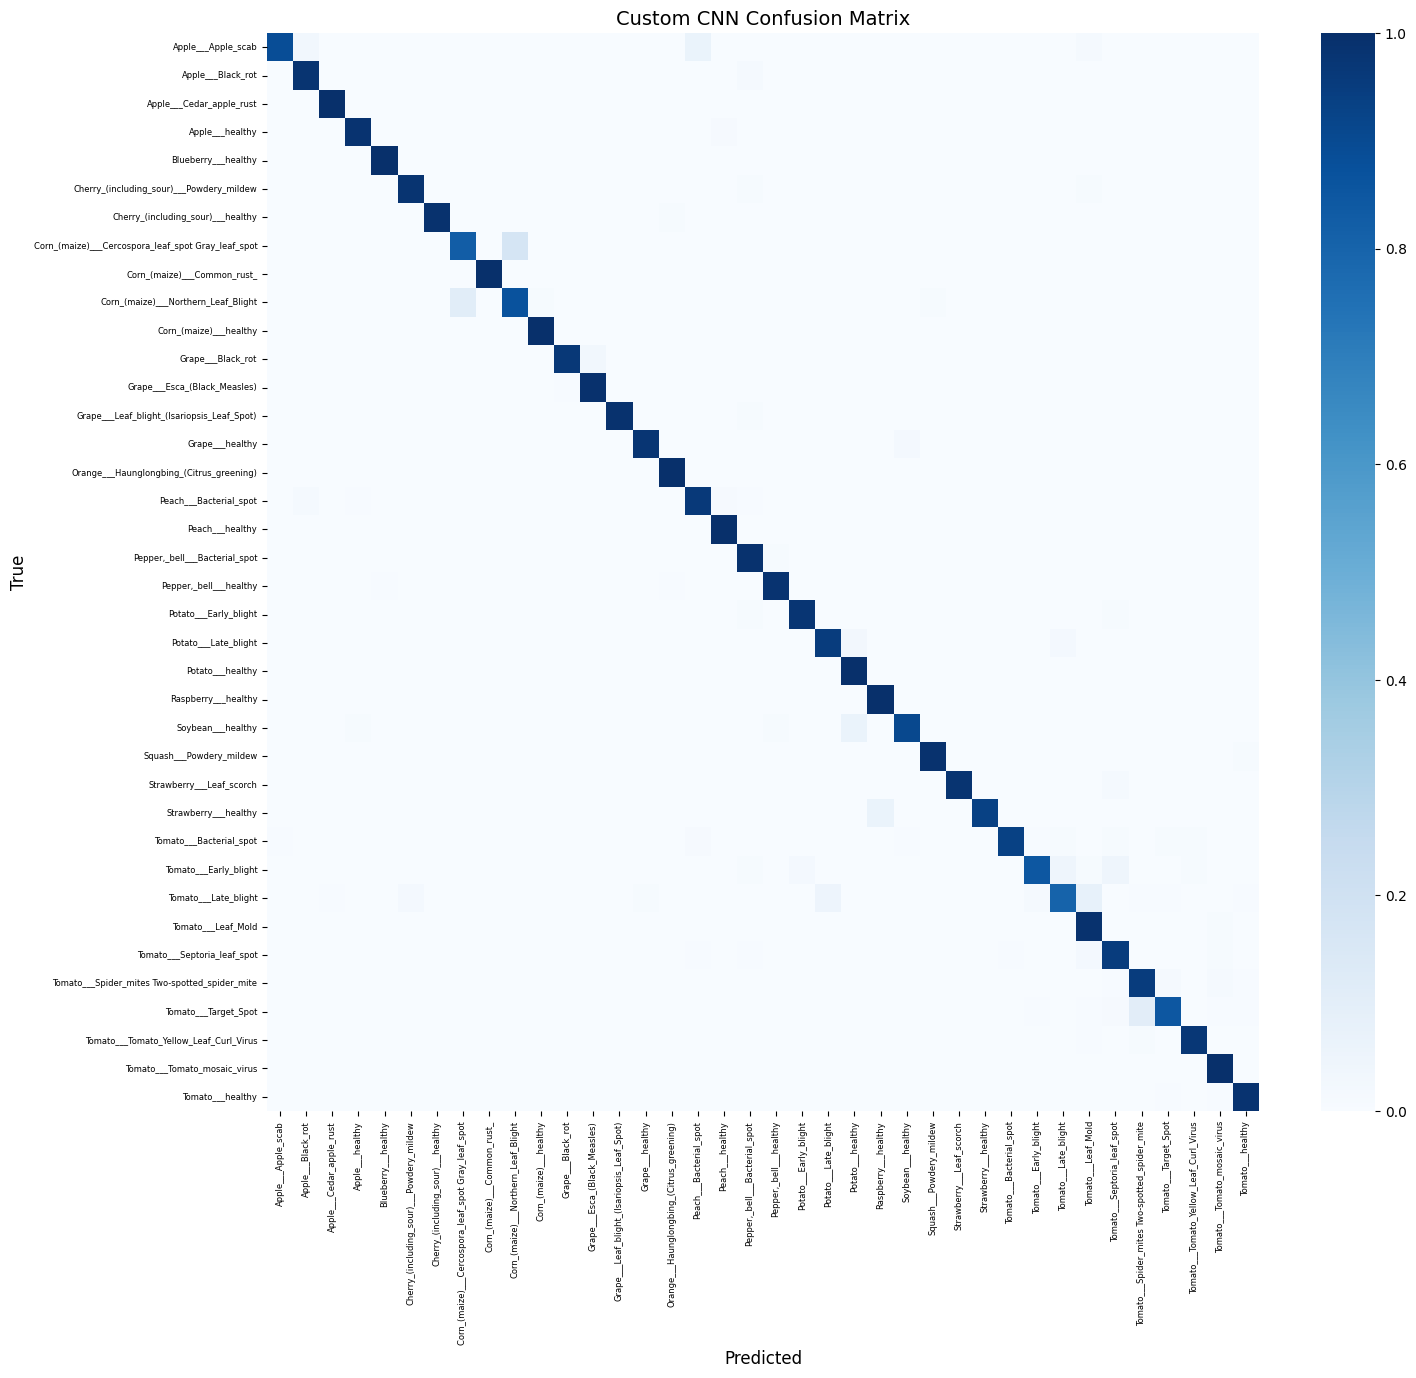

In [12]:
# Custom CNN confusion matrix
cm_cnn = plot_confusion_matrix(
    cnn_results['labels'],
    cnn_results['predictions'],
    class_names,
    'Custom CNN Confusion Matrix',
    config.RESULTS_DIR / 'custom_cnn_confusion_matrix.png'
)

## 8. Per-Class Performance Analysis

In [13]:
# Create per-class comparison
per_class_df = pd.DataFrame({
    'Class': class_names,
    'EfficientNet F1': efficientnet_metrics['f1_per_class'],
    'Custom CNN F1': cnn_metrics['f1_per_class']
})

per_class_df['Difference'] = per_class_df['EfficientNet F1'] - per_class_df['Custom CNN F1']
per_class_df = per_class_df.sort_values('EfficientNet F1', ascending=False)

print("\nPer-Class F1 Scores:")
print(per_class_df.to_string(index=False))


Per-Class F1 Scores:
                                             Class  EfficientNet F1  Custom CNN F1  Difference
                                Apple___Apple_scab         1.000000       0.933333    0.066667
                                 Apple___Black_rot         1.000000       0.946565    0.053435
                          Apple___Cedar_apple_rust         1.000000       0.982456    0.017544
                                   Apple___healthy         1.000000       0.978979    0.021021
          Cherry_(including_sour)___Powdery_mildew         1.000000       0.971963    0.028037
                 Cherry_(including_sour)___healthy         1.000000       0.988372    0.011628
                                  Tomato___healthy         1.000000       0.978328    0.021672
                       Corn_(maize)___Common_rust_         1.000000       1.000000    0.000000
        Grape___Leaf_blight_(Isariopsis_Leaf_Spot)         1.000000       0.995392    0.004608
                            

In [14]:
# Classes where EfficientNet significantly outperforms CNN
print("\nClasses where EfficientNet is significantly better (diff > 0.1):")
better_efficientnet = per_class_df[per_class_df['Difference'] > 0.1]
print(better_efficientnet.to_string(index=False))

# Classes where CNN outperforms EfficientNet
print("\nClasses where Custom CNN is better (diff < -0.05):")
better_cnn = per_class_df[per_class_df['Difference'] < -0.05]
print(better_cnn.to_string(index=False) if len(better_cnn) > 0 else "None")


Classes where EfficientNet is significantly better (diff > 0.1):
                                             Class  EfficientNet F1  Custom CNN F1  Difference
                                Tomato___Leaf_Mold         1.000000       0.871560    0.128440
                      Tomato___Tomato_mosaic_virus         1.000000       0.883721    0.116279
                                  Potato___healthy         1.000000       0.470588    0.529412
                              Tomato___Late_blight         0.997403       0.860335    0.137067
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot         0.945455       0.811321    0.134134

Classes where Custom CNN is better (diff < -0.05):
None


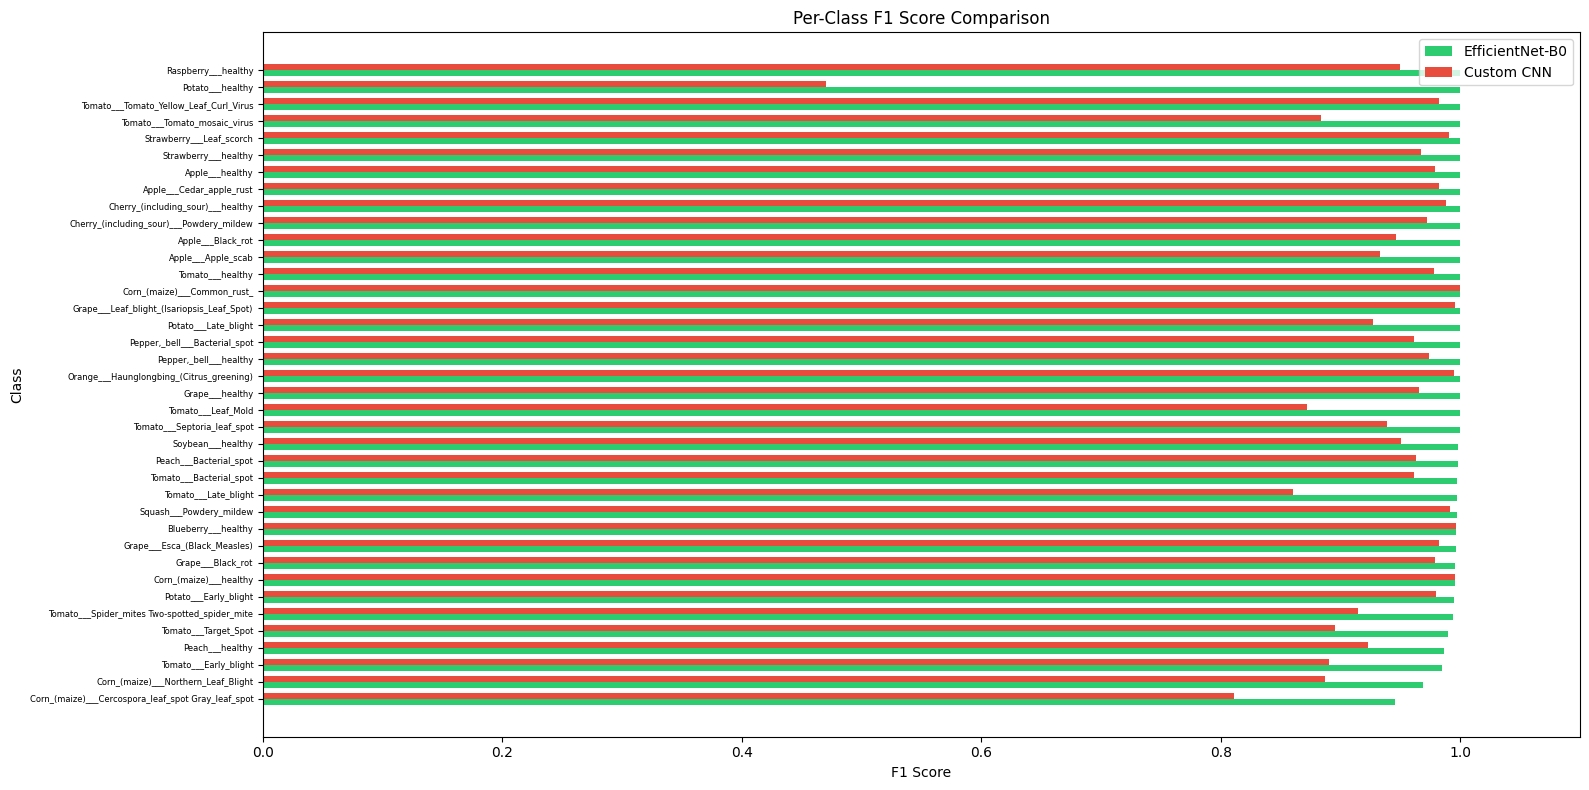

In [15]:
# Visualize per-class F1 comparison
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(class_names))
width = 0.35

# Sort by EfficientNet F1 for better visualization
sorted_df = per_class_df.sort_values('EfficientNet F1', ascending=True)

ax.barh(x - width/2, sorted_df['EfficientNet F1'], width, label='EfficientNet-B0', color='#2ecc71')
ax.barh(x + width/2, sorted_df['Custom CNN F1'], width, label='Custom CNN', color='#e74c3c')

ax.set_xlabel('F1 Score')
ax.set_ylabel('Class')
ax.set_title('Per-Class F1 Score Comparison')
ax.set_yticks(x)
ax.set_yticklabels(sorted_df['Class'], fontsize=6)
ax.legend()
ax.set_xlim(0, 1.1)

plt.tight_layout()
plt.savefig(config.RESULTS_DIR / 'per_class_f1_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Classification Reports

In [16]:
# EfficientNet classification report
print("="*70)
print("EfficientNet-B0 Classification Report")
print("="*70)
print(classification_report(
    efficientnet_results['labels'],
    efficientnet_results['predictions'],
    target_names=class_names,
    digits=4
))

EfficientNet-B0 Classification Report
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     1.0000    1.0000    1.0000        63
                                 Apple___Black_rot     1.0000    1.0000    1.0000        63
                          Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        28
                                   Apple___healthy     1.0000    1.0000    1.0000       165
                               Blueberry___healthy     0.9934    1.0000    0.9967       151
          Cherry_(including_sour)___Powdery_mildew     1.0000    1.0000    1.0000       106
                 Cherry_(including_sour)___healthy     1.0000    1.0000    1.0000        86
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.8966    1.0000    0.9455        52
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000       120
               Corn_(maize)___Northern_Le

In [17]:
# Custom CNN classification report
print("="*70)
print("Custom CNN Classification Report")
print("="*70)
print(classification_report(
    cnn_results['labels'],
    cnn_results['predictions'],
    target_names=class_names,
    digits=4
))

Custom CNN Classification Report
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.9825    0.8889    0.9333        63
                                 Apple___Black_rot     0.9118    0.9841    0.9466        63
                          Apple___Cedar_apple_rust     0.9655    1.0000    0.9825        28
                                   Apple___healthy     0.9702    0.9879    0.9790       165
                               Blueberry___healthy     0.9934    1.0000    0.9967       151
          Cherry_(including_sour)___Powdery_mildew     0.9630    0.9811    0.9720       106
                 Cherry_(including_sour)___healthy     0.9884    0.9884    0.9884        86
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.7963    0.8269    0.8113        52
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000       120
               Corn_(maize)___Northern_Leaf_Bl

## 10. Save Results

In [18]:
# Save comparison results
comparison_df.to_csv(config.RESULTS_DIR / 'model_comparison.csv', index=False)
per_class_df.to_csv(config.RESULTS_DIR / 'per_class_comparison.csv', index=False)

# Save detailed results
results_summary = {
    'efficientnet': {
        'accuracy': float(efficientnet_metrics['accuracy']),
        'f1_macro': float(efficientnet_metrics['f1_macro']),
        'f1_weighted': float(efficientnet_metrics['f1_weighted']),
        'parameters': efficientnet.get_num_params(),
        'model_size_mb': get_model_size(efficientnet),
        'samples_per_second': efficientnet_results['samples_per_second']
    },
    'custom_cnn': {
        'accuracy': float(cnn_metrics['accuracy']),
        'f1_macro': float(cnn_metrics['f1_macro']),
        'f1_weighted': float(cnn_metrics['f1_weighted']),
        'parameters': custom_cnn.get_num_params(),
        'model_size_mb': get_model_size(custom_cnn),
        'samples_per_second': cnn_results['samples_per_second']
    }
}

import json
with open(config.RESULTS_DIR / 'evaluation_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"Results saved to: {config.RESULTS_DIR}")
print(f"  - model_comparison.csv")
print(f"  - per_class_comparison.csv")
print(f"  - evaluation_results.json")
print(f"  - model_comparison.png")
print(f"  - per_class_f1_comparison.png")
print(f"  - efficientnet_confusion_matrix.png")
print(f"  - custom_cnn_confusion_matrix.png")

Results saved to: d:\Repos\plant-disease-project\results
  - model_comparison.csv
  - per_class_comparison.csv
  - evaluation_results.json
  - model_comparison.png
  - per_class_f1_comparison.png
  - efficientnet_confusion_matrix.png
  - custom_cnn_confusion_matrix.png


## 11. Conclusions

In [ ]:
print("\n" + "="*70)
print("EVALUATION SUMMARY")
print("="*70)

# Determine winner
efficientnet_acc = efficientnet_metrics['accuracy']
cnn_acc = cnn_metrics['accuracy']

print(f"\n1. ACCURACY:")
print(f"   - EfficientNet-B0: {efficientnet_acc:.4f}")
print(f"   - Custom CNN: {cnn_acc:.4f}")
acc_diff = abs(efficientnet_acc - cnn_acc) * 100
if efficientnet_acc > cnn_acc:
    print(f"   -> EfficientNet-B0 wins by {acc_diff:.2f}%")
else:
    print(f"   -> Custom CNN wins by {acc_diff:.2f}%")

print(f"\n2. F1 SCORE (Macro):")
print(f"   - EfficientNet-B0: {efficientnet_metrics['f1_macro']:.4f}")
print(f"   - Custom CNN: {cnn_metrics['f1_macro']:.4f}")

print(f"\n3. MODEL EFFICIENCY:")
print(f"   - EfficientNet-B0: {efficientnet.get_num_params():,} params, {get_model_size(efficientnet):.2f} MB")
print(f"   - Custom CNN: {custom_cnn.get_num_params():,} params, {get_model_size(custom_cnn):.2f} MB")

print(f"\n4. INFERENCE SPEED:")
print(f"   - EfficientNet-B0: {efficientnet_results['samples_per_second']:.1f} samples/sec")
print(f"   - Custom CNN: {cnn_results['samples_per_second']:.1f} samples/sec")




EVALUATION SUMMARY

1. ACCURACY:
   - EfficientNet-B0: 0.9971
   - Custom CNN: 0.9560
   -> EfficientNet-B0 wins by 4.10%

2. F1 SCORE (Macro):
   - EfficientNet-B0: 0.9957
   - Custom CNN: 0.9377

3. MODEL EFFICIENCY:
   - EfficientNet-B0: 48,678 params, 15.63 MB
   - Custom CNN: 4,857,286 params, 18.54 MB

4. INFERENCE SPEED:
   - EfficientNet-B0: 1132.7 samples/sec
   - Custom CNN: 935.0 samples/sec

KEY TAKEAWAYS:


## 12. Attention Maps (Grad-CAM Visualization)

Visualize what regions of the image each model focuses on using Gradient-weighted Class Activation Mapping (Grad-CAM).

In [20]:
class GradCAM:
    """
    Grad-CAM implementation for visualizing model attention.
    
    Generates heatmaps showing which regions of an image the model focuses on.
    """
    
    def __init__(self, model, target_layer):
        """
        Initialize Grad-CAM.
        
        Args:
            model: The neural network model
            target_layer: The layer to compute Grad-CAM for
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.handles = []
        
        # Register hooks
        self.handles.append(
            self.target_layer.register_forward_hook(self._save_activations)
        )
        self.handles.append(
            self.target_layer.register_backward_hook(self._save_gradients)
        )
    
    def _save_activations(self, module, input, output):
        """Save forward pass activations."""
        self.activations = output.detach()
    
    def _save_gradients(self, module, grad_input, grad_output):
        """Save backward pass gradients."""
        self.gradients = grad_output[0].detach()
    
    def remove_hooks(self):
        """Remove registered hooks."""
        for handle in self.handles:
            handle.remove()
    
    def generate(self, input_tensor, target_class=None):
        """
        Generate Grad-CAM heatmap.
        
        Args:
            input_tensor: Input image tensor (1, C, H, W)
            target_class: Target class index (if None, uses predicted class)
            
        Returns:
            Tuple of (heatmap, predicted_class, confidence)
        """
        # Enable gradients for this forward pass
        self.model.eval()
        input_tensor = input_tensor.clone().requires_grad_(True)
        
        # Reset stored values
        self.gradients = None
        self.activations = None
        
        # Forward pass
        output = self.model(input_tensor)
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # Get confidence
        probs = torch.softmax(output, dim=1)
        confidence = probs[0, target_class].item()
        
        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Check if gradients were captured
        if self.gradients is None:
            print("Warning: Gradients not captured, returning uniform heatmap")
            heatmap = np.ones((input_tensor.shape[2], input_tensor.shape[3])) * 0.5
            return heatmap, target_class, confidence
        
        # Compute weights (global average pooling of gradients)
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        
        # Weighted combination of activations
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        
        # ReLU and normalize
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        
        # Resize to input size
        cam = torch.nn.functional.interpolate(
            cam, size=(input_tensor.shape[2], input_tensor.shape[3]),
            mode='bilinear', align_corners=False
        )
        
        return cam.squeeze().cpu().numpy(), target_class, confidence


def get_target_layer(model, model_type='efficientnet'):
    """Get the appropriate target layer for Grad-CAM."""
    if model_type == 'efficientnet':
        # Last convolutional layer in EfficientNet
        return model.backbone.features[-1]
    else:
        # Last conv block in Custom CNN
        return model.conv5


print("Grad-CAM class defined.")

Grad-CAM class defined.


In [21]:
# Select sample images from different classes for visualization
from data.dataset import denormalize

def get_sample_images(test_loader, num_samples=6, seed=42):
    """Get sample images from different classes."""
    np.random.seed(seed)
    
    # Collect one image per class
    class_samples = {}
    
    for inputs, labels in test_loader:
        for i in range(len(labels)):
            label = labels[i].item()
            if label not in class_samples:
                class_samples[label] = (inputs[i], label)
            
            if len(class_samples) >= len(class_names):
                break
        if len(class_samples) >= len(class_names):
            break
    
    # Randomly select num_samples classes
    selected_classes = np.random.choice(
        list(class_samples.keys()), 
        size=min(num_samples, len(class_samples)), 
        replace=False
    )
    
    samples = [class_samples[c] for c in selected_classes]
    return samples

# Get sample images
sample_images = get_sample_images(test_loader, num_samples=6)
print(f"Selected {len(sample_images)} sample images from different classes:")

Selected 6 sample images from different classes:


In [22]:
# Create Grad-CAM visualizers for both models
# Need to reload models to avoid gradient issues from previous evaluation
efficientnet_fresh = create_efficientnet_b0(num_classes=config.NUM_CLASSES, pretrained=False)
load_checkpoint(config.EFFICIENTNET_CKPT, efficientnet_fresh)
efficientnet_fresh = efficientnet_fresh.to(config.DEVICE)
efficientnet_fresh.eval()

custom_cnn_fresh = create_custom_cnn(num_classes=config.NUM_CLASSES, variant='standard')
load_checkpoint(config.CNN_CKPT, custom_cnn_fresh)
custom_cnn_fresh = custom_cnn_fresh.to(config.DEVICE)
custom_cnn_fresh.eval()

# Create Grad-CAM instances
gradcam_efficientnet = GradCAM(efficientnet_fresh, get_target_layer(efficientnet_fresh, 'efficientnet'))
gradcam_cnn = GradCAM(custom_cnn_fresh, get_target_layer(custom_cnn_fresh, 'cnn'))

print("Grad-CAM visualizers created for both models.")

Backbone frozen. Only classifier head will be trained.
Grad-CAM visualizers created for both models.


d:\Repos\plant-disease-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
d:\Repos\plant-disease-project\.venv\Lib\site-packages\torch\autograd\graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


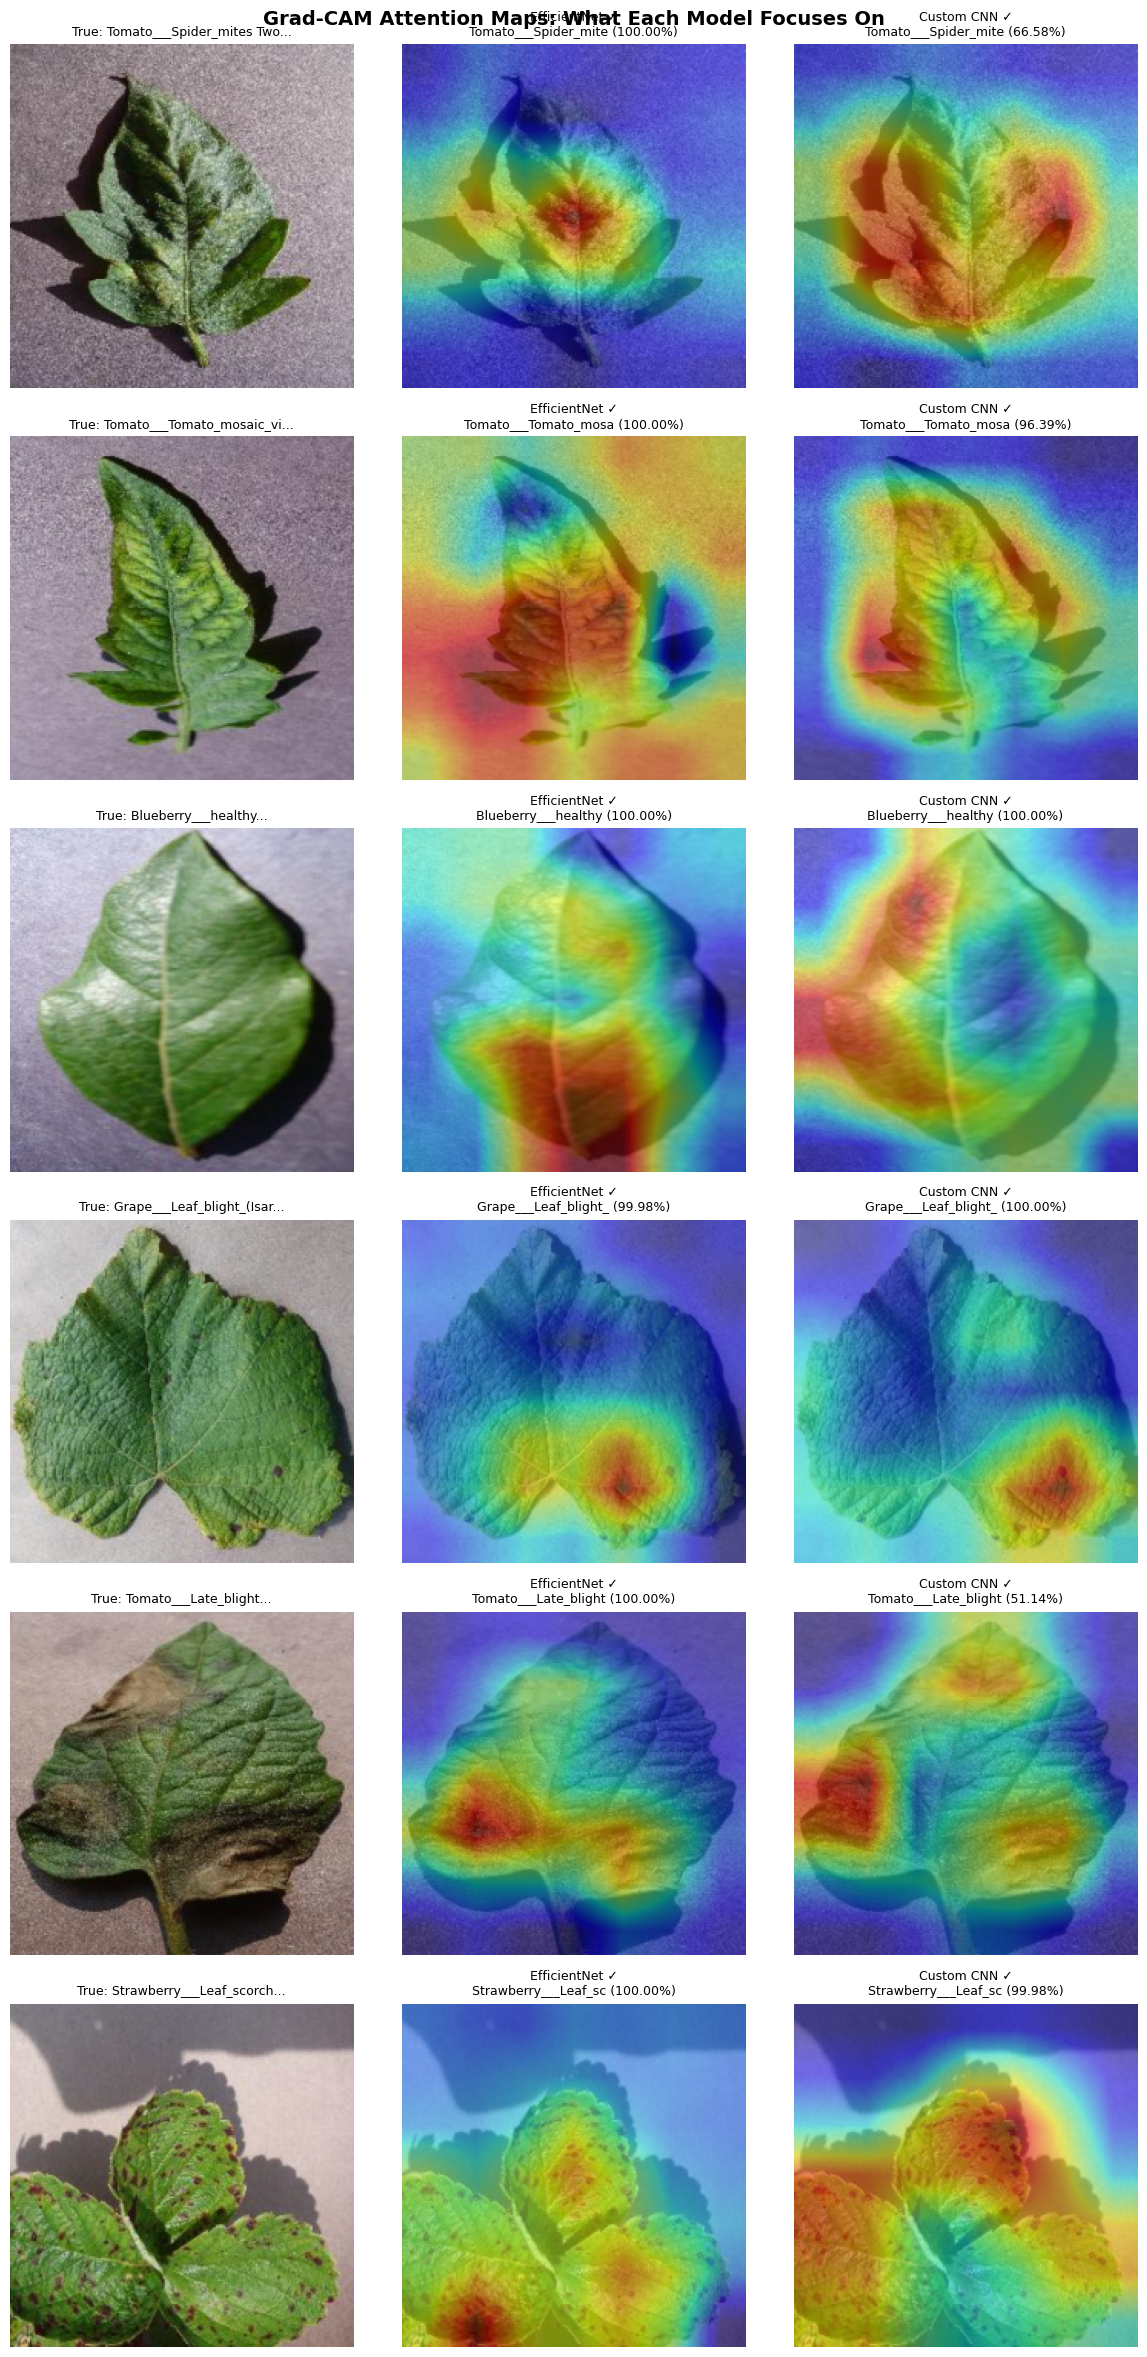


Attention maps saved to: d:\Repos\plant-disease-project\results\attention_maps_comparison.png


In [23]:
def visualize_attention_comparison(sample_images, gradcam_eff, gradcam_cnn, class_names, device, save_path=None):
    """
    Visualize Grad-CAM attention maps for both models side by side.
    
    Shows: Original Image | EfficientNet Attention | Custom CNN Attention
    """
    num_samples = len(sample_images)
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (img_tensor, true_label) in enumerate(sample_images):
        # Prepare input
        input_tensor = img_tensor.unsqueeze(0).to(device)
        
        # Generate Grad-CAM for EfficientNet
        heatmap_eff, pred_eff, conf_eff = gradcam_eff.generate(input_tensor)
        
        # Generate Grad-CAM for Custom CNN  
        heatmap_cnn, pred_cnn, conf_cnn = gradcam_cnn.generate(input_tensor)
        
        # Denormalize image for display
        img_display = denormalize(img_tensor).permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)
        
        # Plot original image
        axes[idx, 0].imshow(img_display)
        axes[idx, 0].set_title(f'True: {class_names[true_label][:25]}...', fontsize=9)
        axes[idx, 0].axis('off')
        
        # Plot EfficientNet attention
        axes[idx, 1].imshow(img_display)
        im1 = axes[idx, 1].imshow(heatmap_eff, cmap='jet', alpha=0.5)
        pred_label_eff = class_names[pred_eff][:20]
        correct_eff = "✓" if pred_eff == true_label else "✗"
        axes[idx, 1].set_title(f'EfficientNet {correct_eff}\n{pred_label_eff} ({conf_eff:.2%})', fontsize=9)
        axes[idx, 1].axis('off')
        
        # Plot Custom CNN attention
        axes[idx, 2].imshow(img_display)
        im2 = axes[idx, 2].imshow(heatmap_cnn, cmap='jet', alpha=0.5)
        pred_label_cnn = class_names[pred_cnn][:20]
        correct_cnn = "✓" if pred_cnn == true_label else "✗"
        axes[idx, 2].set_title(f'Custom CNN {correct_cnn}\n{pred_label_cnn} ({conf_cnn:.2%})', fontsize=9)
        axes[idx, 2].axis('off')
    
    plt.suptitle('Grad-CAM Attention Maps: What Each Model Focuses On', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# Generate attention map comparison
visualize_attention_comparison(
    sample_images, 
    gradcam_efficientnet, 
    gradcam_cnn, 
    class_names, 
    config.DEVICE,
    config.RESULTS_DIR / 'attention_maps_comparison.png'
)

print(f"\nAttention maps saved to: {config.RESULTS_DIR / 'attention_maps_comparison.png'}")

Analyzing attention on 4 samples from: ['Tomato', 'Potato', 'Apple', 'Grape']


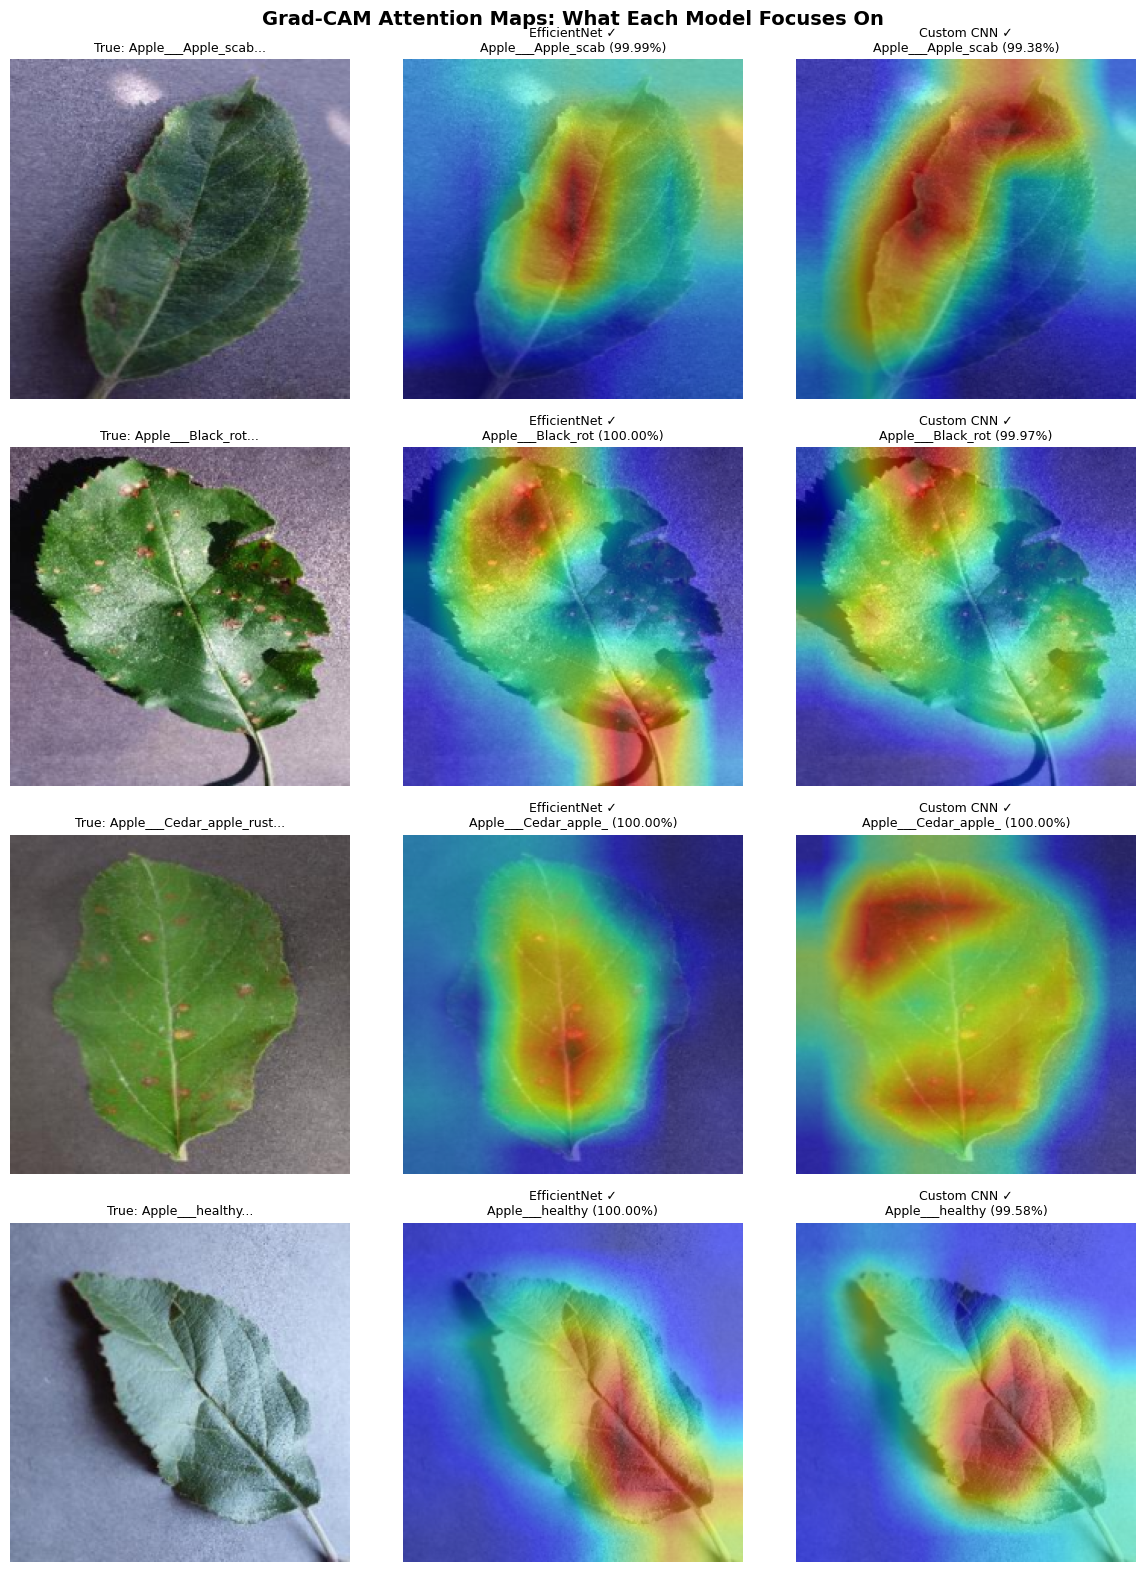

In [24]:
# Visualize specific disease categories for deeper analysis
def get_samples_by_category(test_loader, class_names, categories, num_per_category=1):
    """Get sample images from specific disease categories."""
    samples = []
    category_indices = {name: idx for idx, name in enumerate(class_names) if any(cat in name for cat in categories)}
    
    collected = set()
    for inputs, labels in test_loader:
        for i in range(len(labels)):
            label = labels[i].item()
            if label in category_indices.values() and label not in collected:
                samples.append((inputs[i], label))
                collected.add(label)
            if len(collected) >= len(category_indices):
                break
        if len(collected) >= len(category_indices):
            break
    
    return samples[:num_per_category * len(categories)]

# Get samples from different plant types
plant_categories = ['Tomato', 'Potato', 'Apple', 'Grape']
category_samples = get_samples_by_category(test_loader, class_names, plant_categories, num_per_category=1)

if len(category_samples) > 0:
    print(f"Analyzing attention on {len(category_samples)} samples from: {plant_categories}")
    visualize_attention_comparison(
        category_samples[:4],  # Show up to 4 samples
        gradcam_efficientnet, 
        gradcam_cnn, 
        class_names, 
        config.DEVICE,
        config.RESULTS_DIR / 'attention_maps_by_plant.png'
    )
else:
    print("No samples found for specified categories.")

### Attention Map Observations

**Key insights from the Grad-CAM visualizations:**

1. **EfficientNet-B0** (transfer learning):
   - Tends to focus on more specific disease-related features
   - Benefits from ImageNet pre-training which helps identify textures and patterns
   - Often shows more localized attention on affected leaf regions

2. **Custom CNN** (trained from scratch):
   - May show broader attention patterns across the image
   - Sometimes focuses on different regions compared to EfficientNet
   - Attention patterns reflect features learned specifically from this dataset

3. **Comparison insights:**
   - Both models can correctly identify diseases but may focus on different visual cues
   - Misclassifications often correlate with attention on non-relevant image regions
   - Understanding attention patterns helps explain model behavior and potential failure cases